Let's use our saved models & new prediction data to predict FUTURE year UFCFs for up to 3 years!

In [ ]:
#using our saved RF Model!
import pandas as pd
import numpy as np
from joblib import load
import pickle
from sklearn.metrics import mean_squared_error

# Load the trained Random Forest model
best_rf = load('best_rf_model6.joblib')

# Load the scalers and transformers
scaler = load('standard_scaler6.joblib')
with open('pt_dict6.pkl', 'rb') as f:
    pt_dict = pickle.load(f)
with open('scaler_dict6.pkl', 'rb') as f:
    scaler_dict = pickle.load(f)

# Load the LabelEncoder
le = load('label_encoderrf.joblib')

##### Notice below how the loading of the data has been done in the EXACT same way as when we first trained our models

# Load data
valuation_metrics_path = 'valuation_metrics_official.csv'
processed_data_path = 'processed_data_ml3.csv'
additional_data_path = 'AllDatav2.csv'
historic_data_path = 'merged_predictions_with_future_years22.csv'

valuation_metrics_df = pd.read_csv(valuation_metrics_path)
processed_data_df = pd.read_csv(processed_data_path)
additional_data_df = pd.read_csv(additional_data_path)
historic_data_df = pd.read_csv(historic_data_path)

# Fill NaNs with 0s immediately after loading
valuation_metrics_df = valuation_metrics_df.fillna(0)
processed_data_df = processed_data_df.fillna(0)
additional_data_df = additional_data_df.fillna(0)
historic_data_df = historic_data_df.fillna(0)

# Label encoding for Ticker
processed_data_df['Ticker'] = le.transform(processed_data_df['Ticker'])
valuation_metrics_df['Ticker'] = le.transform(valuation_metrics_df['Ticker'])
additional_data_df['Ticker'] = le.transform(additional_data_df['Ticker'])
historic_data_df['Ticker'] = le.transform(historic_data_df['Ticker'])

columns_to_drop = ['Year']
processed_data_df = processed_data_df.drop(columns=columns_to_drop)

# Select only numeric data in additional_data_df
additional_data_df = additional_data_df.select_dtypes(include=[np.number])

# Merge the datasets
data_df = pd.merge(processed_data_df, valuation_metrics_df, on='Ticker', how='left')
data_df = pd.merge(data_df, additional_data_df, on='Ticker', how='left')
data_df = pd.merge(data_df, historic_data_df, on=['Ticker'], how='left')

# Fill NaNs with 0s after merging
data_df = data_df.fillna(0)

# Drop rows with NaN values resulting from merging
data_df = data_df.select_dtypes(include=[np.number])

# Define features and target
X = data_df.drop(columns=['UFCF'])
y = data_df['UFCF']

# Apply transformations
def transform_features(df):
    transformed_df = df.copy()
    for column in df.columns:
        if column in pt_dict:
            transformed_df[column] = pt_dict[column].transform(df[[column]])
        elif column in scaler_dict:
            transformed_df[column] = scaler_dict[column].transform(df[[column]])
    return transformed_df

# Define years for training and prediction
years = [2024, 2025, 2026]
all_predictions = []

for year in years:
    # Filter data for the current year
    train_data = data_df[data_df['Year'] == year]
    
    # Define features and target for the current year
    X_train = train_data.drop(columns=['UFCF'])
    y_train = train_data['UFCF']
    
    # Transform features for the current year
    X_train_transformed = transform_features(X_train)
    X_train_transformed = X_train_transformed.fillna(0)
    
    # Scale the features
    X_train_scaled = scaler.transform(X_train_transformed)
    
    # Train the model
    best_rf.fit(X_train_scaled, y_train)
    
    # Predict for the current year
    y_train_pred = best_rf.predict(X_train_scaled)
    
    # Evaluate the model
    mse = mean_squared_error(y_train, y_train_pred)
    print(f"Mean Squared Error for year {year}: {mse}")
    
    # Create a DataFrame with Ticker, Year, and Predicted UFCF for this year
    result_df = pd.DataFrame({
        'Ticker': train_data['Ticker'],
        'Year': year,
        'Predicted_UFCF': y_train_pred
    })
    
    # Append the result for this year to the list of all predictions
    all_predictions.append(result_df)

    print(f"Predictions for {year} have been saved.")

# Combine predictions for all years into a single DataFrame
combined_results_df = pd.concat(all_predictions, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_results_df.to_csv('UFCFpredictionsRFfinal.csv', index=False)

print("Combined predictions have been saved to 'combined_predictions_ufcf_with_year.csv'.")


In [ ]:
#Using our saved Neural Network Model!
import pandas as pd
import numpy as np
import yfinance as yf
from joblib import load
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Load the scalers and transformers
scaler = load('standard_scaler6.joblib')
with open('pt_dict6.pkl', 'rb') as f:
    pt_dict = pickle.load(f)
with open('scaler_dict6.pkl', 'rb') as f:
    scaler_dict = pickle.load(f)

# Load the LabelEncoder
le = load('label_encoderrf.joblib')

# Load the pre-trained neural network model
nn_model = load_model('best_nn_model6.h5')  

# Load data
valuation_metrics_path = 'valuation_metrics_official.csv'
processed_data_path = 'processed_data_ml3.csv'
additional_data_path = 'AllDatav2.csv'
historic_data_path = 'merged_predictions_with_future_years22.csv'

valuation_metrics_df = pd.read_csv(valuation_metrics_path)
processed_data_df = pd.read_csv(processed_data_path)
additional_data_df = pd.read_csv(additional_data_path)
historic_data_df = pd.read_csv(historic_data_path)

# Fill NaNs with 0s immediately after loading
valuation_metrics_df = valuation_metrics_df.fillna(0)
processed_data_df = processed_data_df.fillna(0)
additional_data_df = additional_data_df.fillna(0)
historic_data_df = historic_data_df.fillna(0)

# Label encoding for Ticker
processed_data_df['Ticker'] = le.transform(processed_data_df['Ticker'])
valuation_metrics_df['Ticker'] = le.transform(valuation_metrics_df['Ticker'])
additional_data_df['Ticker'] = le.transform(additional_data_df['Ticker'])
historic_data_df['Ticker'] = le.transform(historic_data_df['Ticker'])

columns_to_drop = ['Year']
processed_data_df = processed_data_df.drop(columns=columns_to_drop)

# Select only numeric data in additional_data_df
additional_data_df = additional_data_df.select_dtypes(include=[np.number])

# Merge the datasets
data_df = pd.merge(processed_data_df, valuation_metrics_df, on='Ticker', how='left')
data_df = pd.merge(data_df, additional_data_df, on='Ticker', how='left')
data_df = pd.merge(data_df, historic_data_df, on=['Ticker'], how='left')

# Fill NaNs with 0s after merging
data_df = data_df.fillna(0)

# Drop rows with NaN values resulting from merging
data_df = data_df.select_dtypes(include=[np.number])

# Define features and target
X = data_df.drop(columns=['UFCF'])
y = data_df['UFCF']

# Apply transformations
def transform_features(df):
    transformed_df = df.copy()
    for column in df.columns:
        if column in pt_dict:
            transformed_df[column] = pt_dict[column].transform(df[[column]])
        elif column in scaler_dict:
            transformed_df[column] = scaler_dict[column].transform(df[[column]])
    return transformed_df

# Define years for prediction
years = [2024, 2025, 2026]
predictions_list = []  # List to store predictions for each year

for year in years:
    # Filter data for the current year
    year_data = data_df[data_df['Year'] == year]
    
    # Define features for the current year
    X_year = year_data.drop(columns=['UFCF'])
    
    # Transform and scale features
    X_year_transformed = transform_features(X_year)
    X_year_transformed = X_year_transformed.fillna(0)
    X_year_scaled = scaler.transform(X_year_transformed)
    
    # Predict using the loaded neural network model
    y_year_pred = nn_model.predict(X_year_scaled)
    
    # Evaluate the model (if y_true is available for the same year)
    y_year_true = year_data['UFCF']
    mse = mean_squared_error(y_year_true, y_year_pred)
    print(f"Mean Squared Error for year {year}: {mse}")
    
    # Create a DataFrame with Ticker, Year, and Predicted UFCF for this year
    result_df = pd.DataFrame({
        'Ticker': year_data['Ticker'],
        'Year': year,
        'Predicted_UFCF': y_year_pred.flatten()
    })
    
    # Append the result_df to the predictions list
    predictions_list.append(result_df)

    print(f"Predictions for {year} have been processed.")
    print(result_df.head())

# Combine all predictions into one DataFrame
combined_results_df = pd.concat(predictions_list, axis=0)

# Save the combined result to a CSV file
combined_results_df.to_csv('UFCFpredictionsNNfinal.csv', index=False)

print("Combined predictions have been saved to 'combined_predictions_ufcf_nn.csv'.")


In [ ]:
#merge all the predictions together!

import pandas as pd

# Load processed data from the new CSV with model predictions and company names
processed_data_path = 'modelpredictions+companynames.csv'
processed_data_df = pd.read_csv(processed_data_path)
columns_to_keep = ['Ticker', 'Ticker_encoding', 'UFCF']
processed_data_df = processed_data_df[columns_to_keep]

# Load predictions from neural network and random forest model
# These should already have Ticker_encoding and Year information, along with predicted UFCF
nn_predictions_path = 'UFCFpredictionsNNfinal.csv'  # Replace with actual path
rf_predictions_path = 'UFCFpredictionsRFfinal.csv'  # Replace with actual path

nn_df = pd.read_csv(nn_predictions_path)  # Contains columns like ['Ticker_encoding', 'Year', 'Predicted_UFCF_nn']
rf_df = pd.read_csv(rf_predictions_path)  # Contains columns like ['Ticker_encoding', 'Year', 'Predicted_UFCF_rf']

# Merge the predictions with the processed data on ['Ticker_encoding', 'Year']
merged_df = pd.merge(processed_data_df, nn_df[['Ticker_encoding', 'Year', 'Predicted_UFCF_nn']], on=['Ticker_encoding'], how='left')
merged_df = pd.merge(merged_df, rf_df[['Ticker_encoding','Predicted_UFCF_rf']], on=['Ticker_encoding'], how='left')

# Display the merged DataFrame
print(merged_df.head())

# Optionally save the merged data to a new CSV
merged_df.to_csv('UFCFfinalpredictionsbothmodels.csv', index=False)


Let's compare our predictions against the most current year's actual UFCF, to see how our predictions are doing. 

/var/folders/mf/zm3qz5852hs67j4m4hwml0z80000gn/T/ipykernel_12028/315462178.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticker['Average_Predicted_UFCF'] = (df_ticker['Predicted_UFCF_nn'] + df_ticker['Predicted_UFCF_rf']) / 2


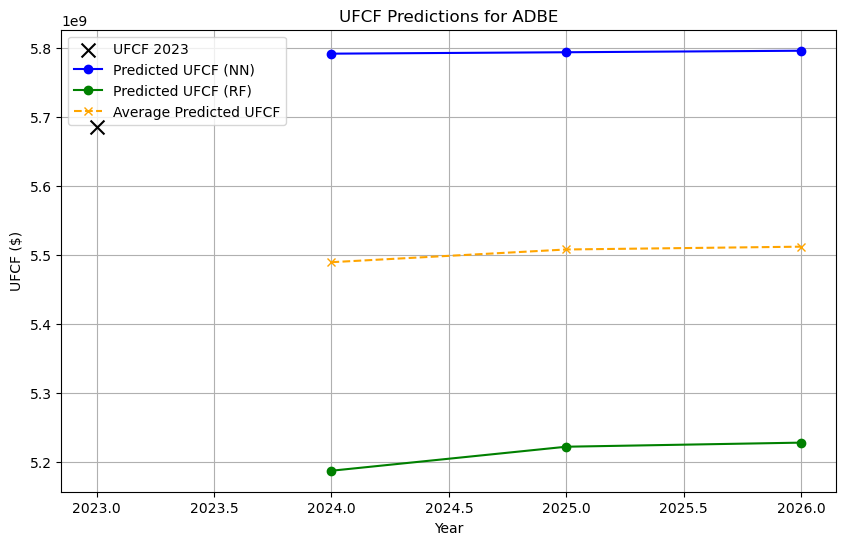

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('UFCFfinalpredictions_unique.csv')

# Filter the data for each Ticker --> used for simplicity purposes!
ticker = 'ADBE'
df_ticker = df[df['Ticker'] == ticker]

# Create the plot
plt.figure(figsize=(10, 6))


ufcf_2023 = df_ticker['UFCF'].iloc[0]  
plt.scatter(2023, ufcf_2023, color='black', marker='x', label='UFCF 2023', s=100, zorder=6)

# Plot the predictions from the neural network model
plt.plot(df_ticker['Year'], df_ticker['Predicted_UFCF_nn'], color='blue', marker='o', label='Predicted UFCF (NN)')

# Plot the predictions from the random forest model
plt.plot(df_ticker['Year'], df_ticker['Predicted_UFCF_rf'], color='green', marker='o', label='Predicted UFCF (RF)')

# Calculate the average of the predicted values
df_ticker['Average_Predicted_UFCF'] = (df_ticker['Predicted_UFCF_nn'] + df_ticker['Predicted_UFCF_rf']) / 2

# Plot the average trend line
plt.plot(df_ticker['Year'], df_ticker['Average_Predicted_UFCF'], color='orange', linestyle='--', marker='x', label='Average Predicted UFCF')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('UFCF ($)')
plt.title(f'UFCF Predictions for {ticker}')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


When experimenting with various tickers, I always noticed that UFCF predictions for future years from the Neural Network, always overshot the predictions, while the random forest undershot the predictions. That's why I created an average line to mitigate these fluctuations. 

All in all, my project served to help investors value businesses by using machine learning and data analysis. For more key insights, check out my Tableau Dashboard and insights google document to learn about how SaaS businesses are doing in today's landscape! In the future, I hope to refine these basic models to improve accuracy and reliability.